In [1]:
import uproot
import numpy as np
import math
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns

c:\Users\muraleed\AppData\Local\anaconda3\envs\mlp\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## Loding root file

The root file contains the branch `sig_adc` and `bkg_adc` which are the adc values of strip cluster matched with rechits and not matched, respectively. The values are then converted to numpy arrays.

In [2]:
path_to_filename = 'C:/Users/muraleed/Documents/StripClusterMLStudies/data/Test.root'
treename = 'stripmlAnalyzer/clusterTree'
variable_list = ['sig_adc','bkg_adc','sig_width', 'bkg_width', 'sig_detId', 'bkg_detId','sig_hitX','sig_hitY', 'sig_hitZ','bkg_hitX','bkg_hitY','bkg_hitZ']
file = uproot.open(path_to_filename)
tree = file[treename]

data = tree.arrays(variable_list,library="np")


In [3]:
def create_meanadc(data):
    listofmean = [np.mean(ele) for ele in data]
    listofstd  = [np.std(ele) for ele in data]
    return np.array(listofmean),np.array(listofstd)


def normalize_v(arr):
    norm = np.linalg.norm(arr)
    if norm == 0:
        return arr
    return arr/norm

## Preparing the dataset

The below function add `mean` and `std` values to the training dataset, and the signal values identified by `1` and background values identified as `0`. Finally, merge these two dataset and shuffle it. 

In [4]:
def create_dataset(rootdata):
    mean_sig_array, std_sig_array = create_meanadc(rootdata['sig_adc'])
    mean_bkg_array, std_bkg_array = create_meanadc(rootdata['bkg_adc'])
    mean_sig_x , std_sig_x = create_meanadc(rootdata['sig_hitX'])
    mean_sig_y , std_sig_y = create_meanadc(rootdata['sig_hitY'])
    mean_sig_z , std_sig_y = create_meanadc(rootdata['sig_hitZ'])
    mean_bkg_x , std_bkg_x = create_meanadc(rootdata['bkg_hitX'])
    mean_bkg_y , std_bkg_y = create_meanadc(rootdata['bkg_hitY'])
    mean_bkg_z , std_bkg_y = create_meanadc(rootdata['bkg_hitZ'])
    sig_width = rootdata['sig_width']
    bkg_width = rootdata['bkg_width']
    sig_detId = normalize_v(rootdata['sig_detId'])
    bkg_detId = normalize_v(rootdata['bkg_detId'])
    dict_sig = {'mean':mean_sig_array,'std':std_sig_array, 'width':sig_width, 'hitX':mean_sig_x,'hitY':mean_sig_y,'detId': sig_detId,'hitZ':mean_sig_z}
    dict_bkg = {'mean':mean_bkg_array,'std':std_bkg_array, 'width':bkg_width, 'hitX':mean_bkg_x,'hitY':mean_bkg_y,'detId': bkg_detId,'hitZ':mean_bkg_z}
    signal_df = pd.DataFrame(dict_sig)
    background_df = pd.DataFrame(dict_bkg)
    signal_df['value'] = 1
    background_df['value'] = 0
    frames = [signal_df,background_df]
    results = pd.concat(frames)
    results = results.sample(frac=1)
    return results

In [5]:
dataset = create_dataset(data)

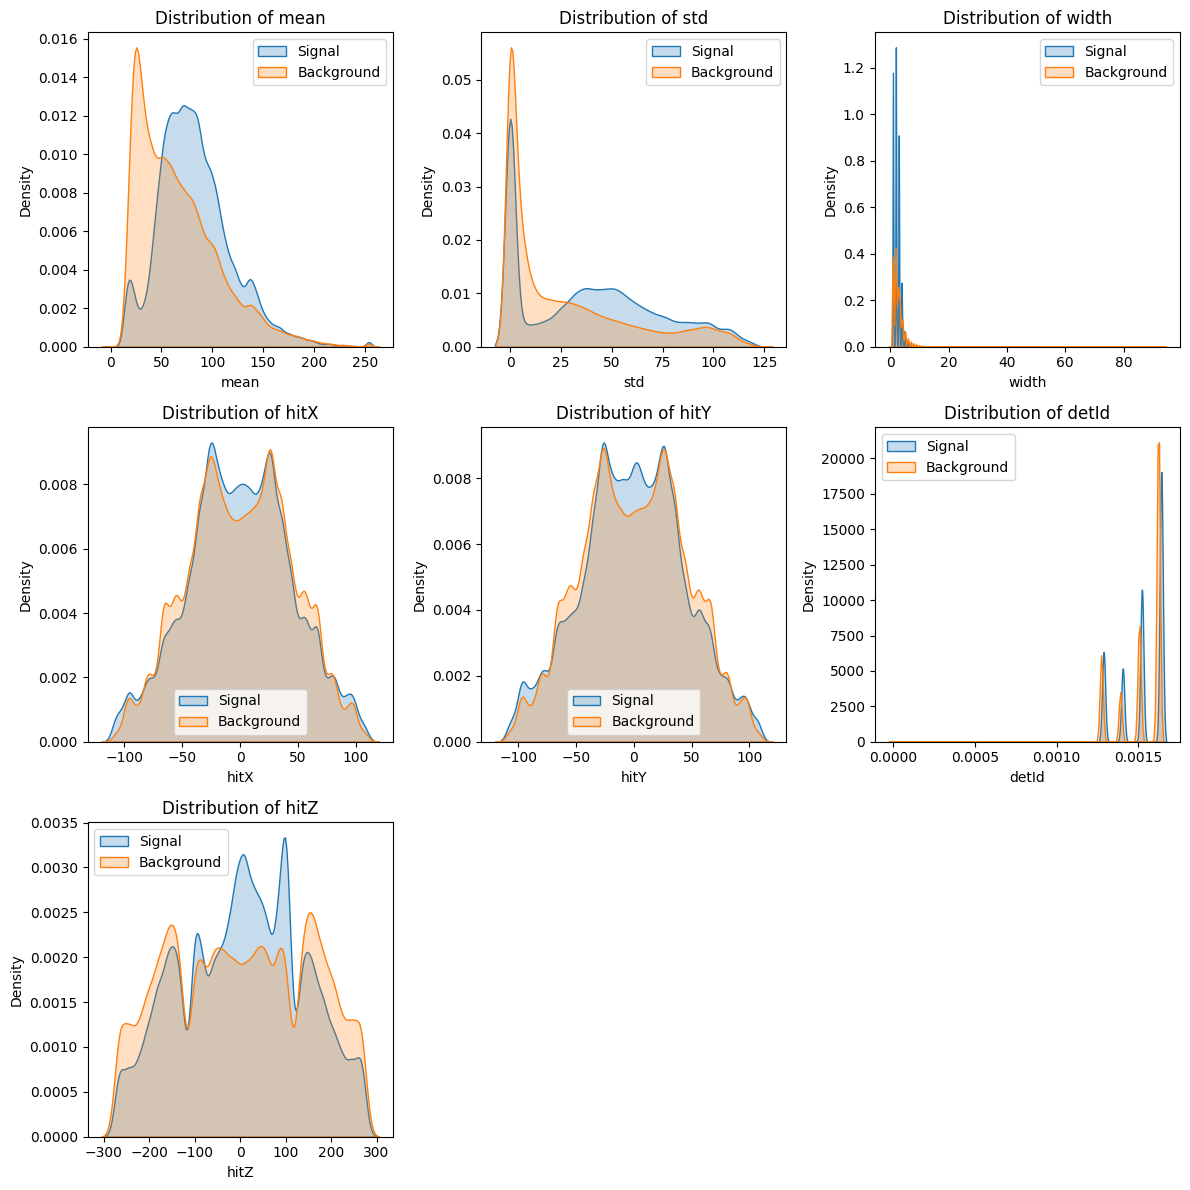

In [6]:
dataset_tmp = dataset.drop(['value'],axis=1)
features = dataset_tmp.keys()
num_features = len(features)

# Grid size: 3 columns
n_cols = 3
n_rows = math.ceil(num_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
axes = axes.flatten()  # make indexing easier

for idx, feat in enumerate(features):
    ax = axes[idx]
    sns.kdeplot(dataset[dataset['value'] == 1][feat], label='Signal', fill=True, ax=ax)
    sns.kdeplot(dataset[dataset['value'] == 0][feat], label='Background', fill=True, ax=ax)
    ax.set_title(f'Distribution of {feat}')
    ax.set_xlabel(feat)
    ax.set_ylabel('Density')
    ax.legend()

# Remove any unused subplots
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [7]:
xdata = dataset.drop(['value'],axis=1).to_numpy(dtype='float32')
ydata = dataset['value'].to_numpy(dtype='float32')

In [8]:
x_train, x_test , y_train, y_test = train_test_split(xdata,ydata,test_size=0.33,random_state=42)

## Model selection

It is binary classification with seven features. The `Sequential` model is enough for the classification.

    1. Mean ADC values
    2. Standard deviation of ADC values
    3. Width of the cluster
    4. detId
    5. Hit position X
    6. Hit position Y
    7. Hit position Z

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64,activation='relu',input_shape=(7,)),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dense(8,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


c:\Users\muraleed\AppData\Local\anaconda3\envs\mlp\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',        # Metric to monitor
    patience=10,               # Stop after 5 epochs with no improvement
    restore_best_weights=True  # Optional: restore weights from best epoch
)

In [12]:
history = model.fit(x_train, y_train, epochs=1000, batch_size=128, validation_split=0.2, callbacks=[early_stop])

Epoch 1/1000
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6553 - loss: 0.6733 - val_accuracy: 0.6973 - val_loss: 0.5978
Epoch 2/1000
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7026 - loss: 0.5891 - val_accuracy: 0.7234 - val_loss: 0.5512
Epoch 3/1000
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7229 - loss: 0.5480 - val_accuracy: 0.7254 - val_loss: 0.5342
Epoch 4/1000
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7294 - loss: 0.5309 - val_accuracy: 0.7325 - val_loss: 0.5236
Epoch 5/1000
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7339 - loss: 0.5236 - val_accuracy: 0.7383 - val_loss: 0.5161
Epoch 6/1000
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7365 - loss: 0.5195 - val_accuracy: 0.7371 - val_loss: 0.5177
Epoch 7/1000
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7399 - loss: 0.5150 - val_accuracy: 0.7423 - val_loss: 0.5128
Epoch 8/1000
3573/3573 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7394 -

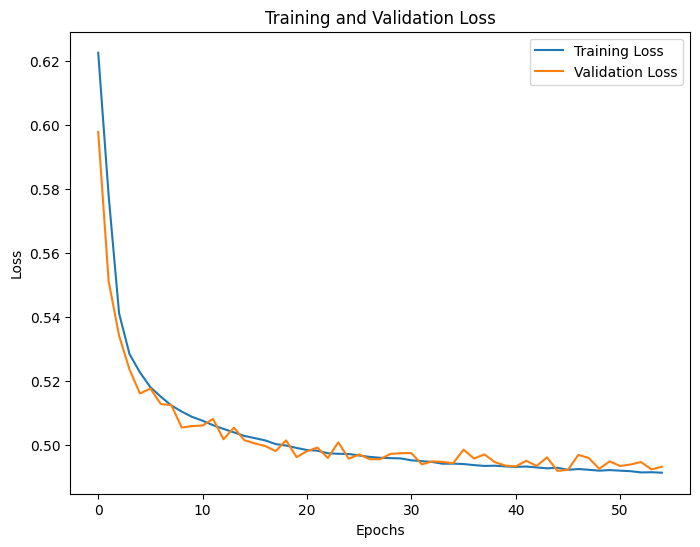

In [13]:
# Extract loss value
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss curves
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
#model.save("classifier_model.h5")

In [14]:
# Predict probabilities (not hard class labels)
y_train_pred = model.predict(x_train).ravel()
y_test_pred = model.predict(x_test).ravel()

# Compute ROC curve and AUC for train and test
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)

17864/17864 ━━━━━━━━━━━━━━━━━━━━ 14s 758us/step
8799/8799 ━━━━━━━━━━━━━━━━━━━━ 7s 757us/step


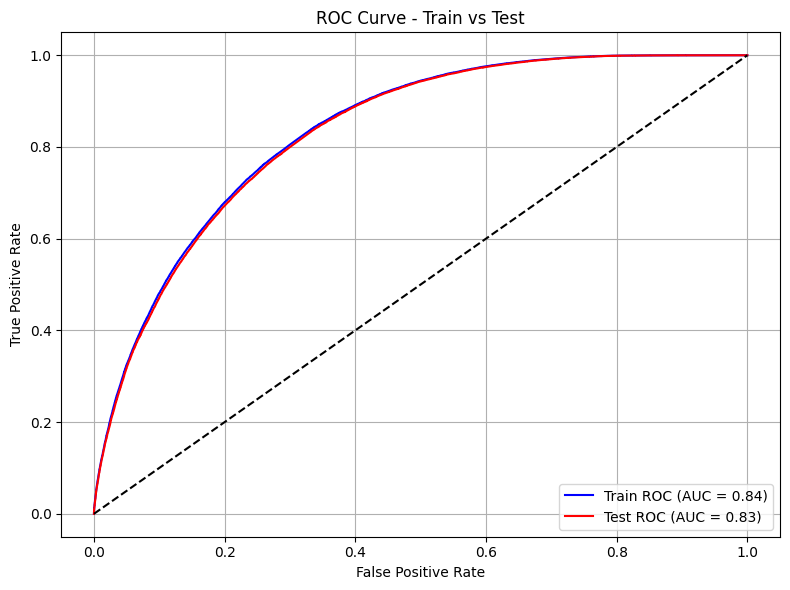

In [15]:
# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {roc_auc_train:.2f})', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {roc_auc_test:.2f})', color='red')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Train vs Test')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


Text(0.5, 0, 'DNN score')

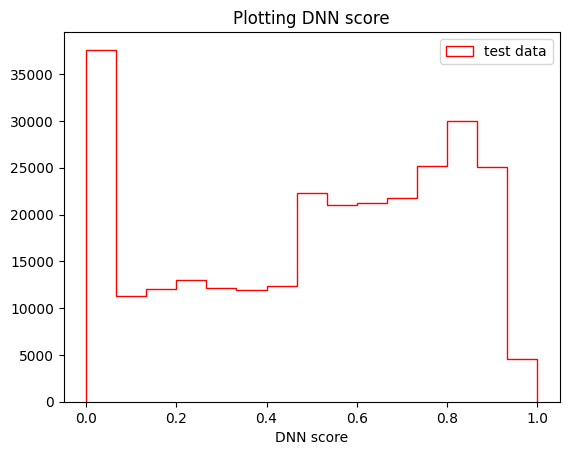

In [16]:
plt.title('Plotting DNN score')
plt.hist(y_test_pred,bins=15,histtype='step',range=[0,1],color='r',label='test data')
plt.legend()
plt.xlabel('DNN score')

## Testing with Approx SiStrip clusters

First preparing the data

In [18]:
path_to_filename = 'C:/Users/muraleed/Documents/StripClusterMLStudies/data/TestApproxCluster.root'
treename = 'stripmlAnalyzer/clusterTree'
variable_list = ['sig_adc','bkg_adc','sig_width', 'bkg_width', 'sig_detId', 'bkg_detId','sig_hitX','sig_hitY', 'sig_hitZ','bkg_hitX','bkg_hitY','bkg_hitZ']
file_star = uproot.open(path_to_filename)
tree = file_star[treename]

data_star = tree.arrays(variable_list,library="np")


In [19]:
rawprime_dataset = create_dataset(data_star)

In [20]:
xstar = rawprime_dataset.drop(['value'],axis=1).to_numpy(dtype='float32')
ystar = rawprime_dataset['value'].to_numpy(dtype='float32')

In [22]:
y_star_pred = model.predict(xstar).ravel()
fpr_star, tpr_star, _ = roc_curve(ystar, y_star_pred)
roc_auc_star = auc(fpr_star, tpr_star)

433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step


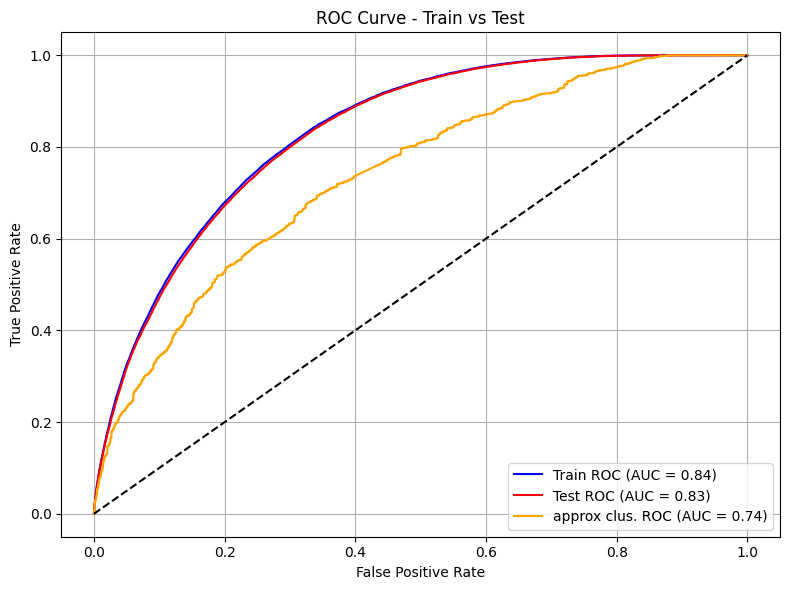

In [24]:
# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {roc_auc_train:.2f})', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {roc_auc_test:.2f})', color='red')
plt.plot(fpr_star, tpr_star, label=f'approx clus. ROC (AUC = {roc_auc_star:.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Train vs Test')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()